Object localization with classification head (Short introduction to multiple outputs)

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, MaxPooling2D, Conv2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from matplotlib.image import imread
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import  train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


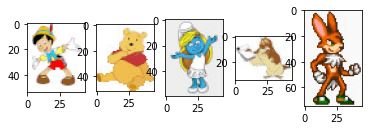

In [3]:
path = '/content/gdrive/My Drive/Colab Notebooks/postacie/'
data = []

for i in range(5):
    plt.subplot(1,5, i+1)
    filename = path + str(i+1) + '.jpg'
    image = imread(filename)
    data.append(image)
    plt.imshow(image)
plt.show()

In [4]:
label_reader = {0: 'Pinokio', 1: 'Puchatek', 2: 'Smerfetka', 3: 'Sowa', 4: 'Surge'}

In [5]:
data[1].shape

(52, 45, 3)

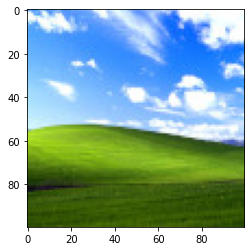

In [6]:
bg_filename = '/content/gdrive/My Drive/Colab Notebooks/' + 'tlo2.jpg'
bg = imread(bg_filename)
plt.imshow(bg)
plt.show()

In [7]:
bg.shape

(100, 100, 3)

In [8]:
len(data)

5

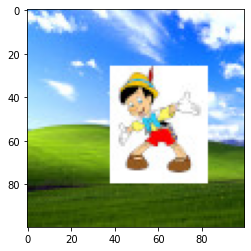

In [77]:
def gen_dataset():
  dataset = np.zeros((1000, 100, 100, 3))
  Y_label = []
  Y_bbox = []
  for i in range(1000):
    dataset[i] = bg
  dataset = dataset.astype(int)

  picture = 0
  for pic in range(5):
    for i in range(200):
        x = np.random.randint(0,bg.shape[1]-data[pic].shape[1])
        y = np.random.randint(0,bg.shape[0]-data[pic].shape[0])
        for x_i in range(data[pic].shape[1]):
          for y_i in range(data[pic].shape[0]):
            for z_i in range(3):
              dataset[picture][y+y_i][x+x_i][z_i] = data[pic][y_i][x_i][z_i]
        Y_label.append(to_categorical(pic, num_classes=len(data)))
        Y_bbox.append(np.array([x, y, x+data[pic].shape[1], y+data[pic].shape[0]]))
        picture +=1

  return dataset, Y_label, Y_bbox

# sanity check - plot the images
x_train, y_label, y_bbox = gen_dataset()
plt.imshow(x_train[0])

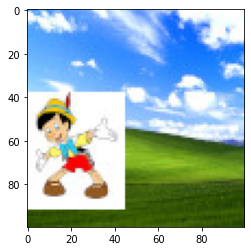

In [78]:
plt.imshow(x_train[10])

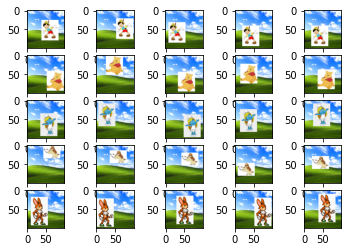

In [79]:
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(x_train[i*40])

In [80]:
y_label = np.asarray(y_label)

In [81]:
y_bbox = np.asarray(y_bbox)
y_bbox = y_bbox/100
y_bbox

array([[0.38, 0.26, 0.83, 0.8 ],
       [0.15, 0.08, 0.6 , 0.62],
       [0.19, 0.38, 0.64, 0.92],
       ...,
       [0.  , 0.04, 0.45, 0.79],
       [0.47, 0.12, 0.92, 0.87],
       [0.52, 0.05, 0.97, 0.8 ]])

In [82]:
y_bbox.max()

0.99

In [83]:
x_train = x_train/255.

In [84]:
print(x_train.shape, y_label.shape, y_bbox.shape)

(1000, 100, 100, 3) (1000, 5) (1000, 4)


In [85]:
(X_train, X_test, Y_train_labels, Y_test_labels, Y_train_bboxes, Y_test_bboxes) = train_test_split(x_train, y_label, y_bbox, test_size=0.2, random_state=42, stratify=y_label)

In [18]:
def get_model():
    inputs = Input(shape=(100,100,3))
    x = Conv2D(32, (3,3), activation='relu')(inputs)
    x = MaxPooling2D((3,3))(x)
    x = Conv2D(32, (3,3), activation='relu')(x)
    x = MaxPooling2D((3,3))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    classifier_head = Dropout(0.3)(x)
    classifier_head = Dense(5, activation='softmax', name='label')(classifier_head)

    reg_head = Dense(64, activation='relu')(x)
    reg_head = Dense(32, activation='relu')(reg_head)
    reg_head = Dense(4, activation='sigmoid', name='bbox')(reg_head)

    return Model(inputs=[inputs], outputs=[classifier_head, reg_head])

In [19]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 98, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 30, 32)   9248        max_pooling2d[0][0]              
______________________________________________________________________________________________

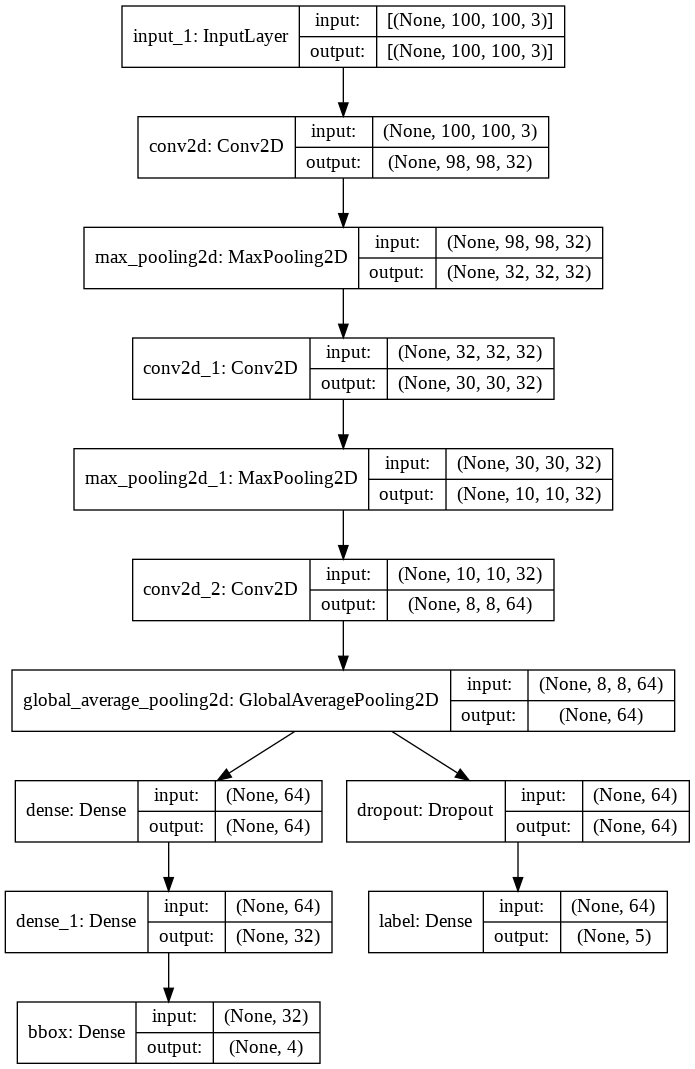

In [20]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=True )


In [21]:
# losses declaration
losses = {'label': 'categorical_crossentropy',
          'bbox': 'mse'}

loss_weights = {'label': 1.0,
                'bbox': 1.0}

In [22]:
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [23]:
model.compile('adam', loss=losses, loss_weights=loss_weights, metrics=['acc'])

model.fit(X_train, y={'label': Y_train_labels, 'bbox': Y_train_bboxes},
          epochs=50,
          validation_data = (X_test, {'label': Y_test_labels, 'bbox': Y_test_bboxes}),
          callbacks=[early_stopper])

Epoch 1/50
25/25 [==============================] - 34s 35ms/step - loss: 1.6709 - label_loss: 1.5967 - bbox_loss: 0.0742 - label_acc: 0.2160 - bbox_acc: 0.3691 - val_loss: 1.4653 - val_label_loss: 1.4401 - val_bbox_loss: 0.0251 - val_label_acc: 0.4000 - val_bbox_acc: 0.5550
Epoch 2/50
25/25 [==============================] - 0s 12ms/step - loss: 1.4116 - label_loss: 1.3863 - bbox_loss: 0.0253 - label_acc: 0.3745 - bbox_acc: 0.5826 - val_loss: 1.1482 - val_label_loss: 1.1249 - val_bbox_loss: 0.0233 - val_label_acc: 0.5650 - val_bbox_acc: 0.4350
Epoch 3/50
25/25 [==============================] - 0s 12ms/step - loss: 1.1559 - label_loss: 1.1318 - bbox_loss: 0.0242 - label_acc: 0.4887 - bbox_acc: 0.5195 - val_loss: 0.9278 - val_label_loss: 0.9070 - val_bbox_loss: 0.0209 - val_label_acc: 0.7750 - val_bbox_acc: 0.5550
Epoch 4/50
25/25 [==============================] - 0s 12ms/step - loss: 0.9519 - label_loss: 0.9297 - bbox_loss: 0.0221 - label_acc: 0.5816 - bbox_acc: 0.5826 - val_loss: 0.

In [24]:
def show_result(img_index):
  test_img = X_test[img_index].reshape(1, 100, 100, 3)

  predicted_data = model.predict(test_img)

  label = np.argmax(predicted_data[0][0])
  bbox = predicted_data[1][0]
  print(bbox)

  plt.figure()
  img = cv2.rectangle(X_test[img_index],(int(bbox[0]*100),int(bbox[1]*100)),(int(bbox[2]*100),int(bbox[3]*100)),(255,0,0),2)
  plt.imshow(img)
  print('\n', label_reader[label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.41417956 0.20156047 0.8237595  0.89770603]

 Surge


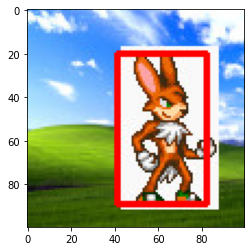

In [25]:
show_result(5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.24701303 0.08696475 0.718479   0.57630277]

 Puchatek


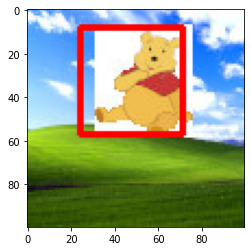

In [26]:
show_result(199)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.22059067 0.36316013 0.66426307 0.9159979 ]

 Smerfetka


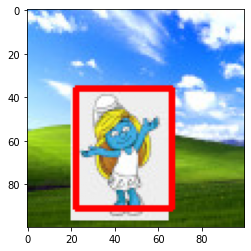

In [27]:
show_result(100)

# Próba zwiększenia skuteczności rozpoznawania położenia obiektów

In [86]:
def get_model():
    inputs = Input(shape=(100,100,3))
    x = Conv2D(32, (3,3), activation='relu')(inputs)
    x = MaxPooling2D((3,3))(x)
    x = Conv2D(32, (3,3), activation='relu')(x)
    x = MaxPooling2D((3,3))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    classifier_head = Dropout(0.3)(x)
    classifier_head = Dense(5, activation='softmax', name='label')(classifier_head)

    reg_head = Dense(64, activation='relu')(x)
    reg_head = Dense(64, activation='relu')(reg_head)
#    reg_head = Dense(16, activation='relu')(reg_head)
    reg_head = Dense(4, activation='sigmoid', name='bbox')(reg_head)

    return Model(inputs=[inputs], outputs=[classifier_head, reg_head])

In [87]:
model = get_model()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 98, 98, 32)   896         input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 32, 32, 32)   0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 30, 30, 32)   9248        max_pooling2d_10[0][0]           
____________________________________________________________________________________________

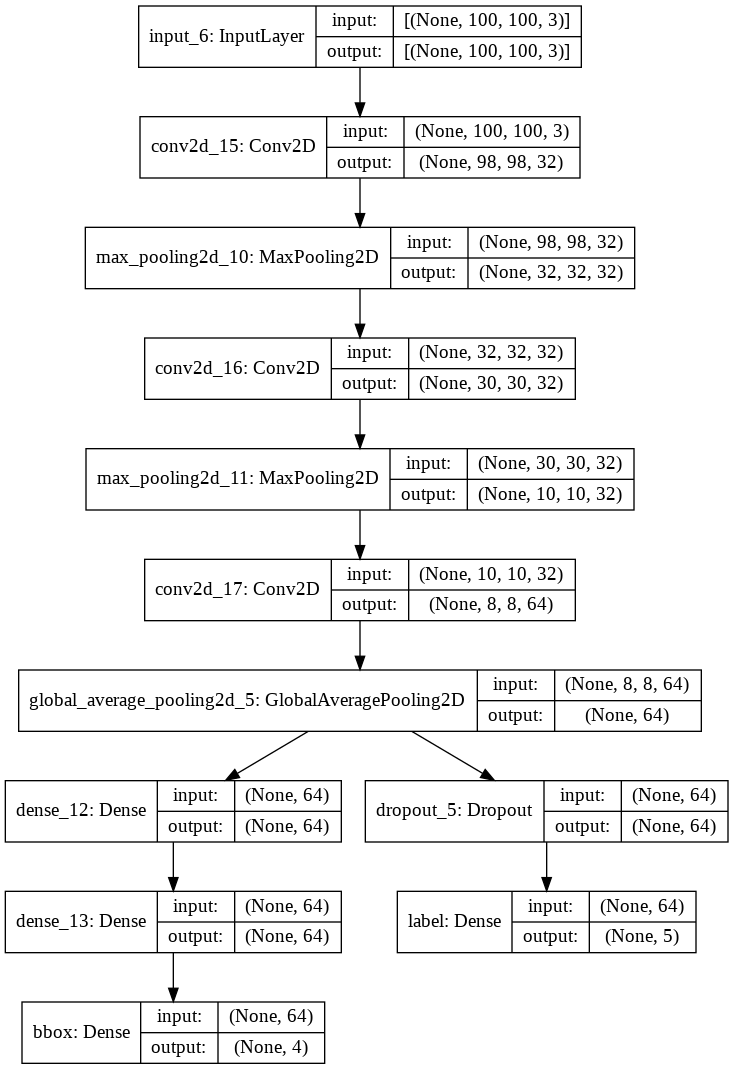

In [88]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=True )

In [89]:
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='bbox_acc', patience=5, restore_best_weights=True)

model.compile('adam', loss=losses, loss_weights=loss_weights, metrics=['acc'])

model.fit(X_train, y={'label': Y_train_labels, 'bbox': Y_train_bboxes},
          epochs=50,
          validation_data = (X_test, {'label': Y_test_labels, 'bbox': Y_test_bboxes}),
          callbacks=[early_stopper])

Epoch 1/50
25/25 [==============================] - 1s 23ms/step - loss: 1.6900 - label_loss: 1.6124 - bbox_loss: 0.0776 - label_acc: 0.2025 - bbox_acc: 0.5125 - val_loss: 1.5922 - val_label_loss: 1.5544 - val_bbox_loss: 0.0378 - val_label_acc: 0.4000 - val_bbox_acc: 0.5000
Epoch 2/50
25/25 [==============================] - 0s 12ms/step - loss: 1.5301 - label_loss: 1.5002 - bbox_loss: 0.0299 - label_acc: 0.3533 - bbox_acc: 0.5865 - val_loss: 1.2919 - val_label_loss: 1.2677 - val_bbox_loss: 0.0241 - val_label_acc: 0.6100 - val_bbox_acc: 0.6050
Epoch 3/50
25/25 [==============================] - 0s 11ms/step - loss: 1.2705 - label_loss: 1.2459 - bbox_loss: 0.0246 - label_acc: 0.4623 - bbox_acc: 0.5527 - val_loss: 1.0747 - val_label_loss: 1.0513 - val_bbox_loss: 0.0234 - val_label_acc: 0.4000 - val_bbox_acc: 0.6650
Epoch 4/50
25/25 [==============================] - 0s 12ms/step - loss: 1.0415 - label_loss: 1.0183 - bbox_loss: 0.0232 - label_acc: 0.5487 - bbox_acc: 0.6073 - val_loss: 0.8

[0.17529045 0.15588354 0.68678087 0.8964611 ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Surge


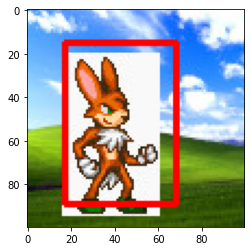

In [90]:
show_result(5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.23504409 0.162719   0.7353436  0.7054025 ]

 Puchatek


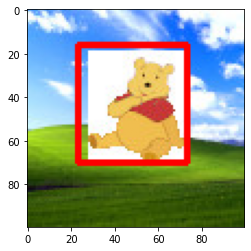

In [91]:
show_result(199)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.13626994 0.1435746  0.5757941  0.7404948 ]

 Smerfetka


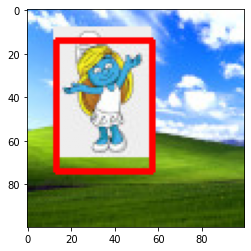

In [92]:
show_result(100)

Wniosek: W celu zwiększenia skuteczności rozpoznawania położenia obiektów przez sieć lepiej zwiększyć ilość neuronów w istniejących warstwach dense niż dodawać nowe warstwy (sprawdzono 3 przypadki: dodanie warstwy dense(16), zmniejszenie liczby neuronów z 32 do 16, zwiększenie liczby neuronów z 32 do 64 - ostatni przypadek sprawdził się najlepiej).